<a href="https://colab.research.google.com/github/JulioLaz/Movie_Recommender_System_ML/blob/main/Movie_Recommender_System_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROBLEMA DE NEGOCIO**


---




##Imagina tener acceso a los datos de una plataforma de streaming y usar esos datos para mejorar la experiencia del usuario. Como científicos de datos, analizarán estos datos con Python y construirán un recomendador de películas personalizado que ofrecerá sugerencias precisas y relevantes, revolucionando la forma en que los usuarios descubren nuevos contenidos.

### **Objetivos**

1. Recomendador no personalizado

2. Recomendador Content-based

3. Recomendador Collaborative filtering

#**1. Configuración del Ambiente**


---




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies, df_ratings, df_final,df_poster,df_links
path_img = 'https://i0.wp.com/image.tmdb.org/t/p/w300'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   358k      0  0:00:02  0:00:02 --:--:--  358k


#**2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




##**2.1 Cargando las bases de datos**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
# df_movies.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/movies.csv', index=False)
df_movies = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/movies.csv')
df_movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
# df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
# df_ratings.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/ratings.csv', index=False)
df_ratings = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/ratings.csv')
df_ratings.head()

userId  movieId  rating  timestamp
0       1        1    4.00  964982703
1       1        3    4.00  964981247
2       1        6    4.00  964982224
3       1       47    5.00  964983815
4       1       50    5.00  964982931

In [6]:
# df_tags = pd.read_csv('data/ml-latest-small/tags.csv')
# df_tags.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/tags.csv', index=False)
df_tags = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/tags.csv')
df_tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

In [7]:
df_links = pd.read_csv('data/ml-latest-small/links.csv')
# df_links.to_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/links.csv', index=False)
df_links = pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/links.csv')
df_links = df_links[['movieId','imdbId']]
df_links['imdbId'] = df_links['imdbId'].apply(lambda x: f"tt{x:07d}")
df_links.head()

movieId     imdbId
0        1  tt0114709
1        2  tt0113497
2        3  tt0113228
3        4  tt0114885
4        5  tt0113041

In [8]:
df_poster=pd.read_csv('/content/drive/MyDrive/Bootcamp-Alejo-projects/movie_recommender/df_merged_poster_links.csv')
df_poster.head()

movieId    imdb_id                       poster_path
0        1  tt0114709  /uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1        2  tt0113497  /vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg
2        3  tt0113228  /1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg
3        4  tt0114885  /4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg
4        5  tt0113041  /rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg

In [9]:
#buscar los valores de la col imdb_id que no contengan tt:
len(df_poster[df_poster['imdb_id'].str.startswith('tt')])

9637

In [10]:
df_merge_movies_links = pd.merge(df_movies, df_links, on='movieId')
df_merge_movies_links.head(2)

movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        2    Jumanji (1995)                   Adventure|Children|Fantasy   

      imdbId  
0  tt0114709  
1  tt0113497

In [11]:
df_merge_movies_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   imdbId   9742 non-null   object
dtypes: int64(1), object(3)
memory usage: 304.6+ KB


In [12]:
df_merge_movies_links[df_merge_movies_links['imdbId']==417]

Empty DataFrame
Columns: [movieId, title, genres, imdbId]
Index: []

##**2.2 Tratamiento de Datos**

In [13]:
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')
print(df_poster.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9637 entries, 0 to 9636
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movieId      9637 no

In [14]:
def preprocesamiento():
    global df_movies, df_ratings, df_final, df_poster

    df_movies = df_movies.dropna()
    df_ratings = df_ratings.dropna()
    df_poster = df_poster.dropna()
    df_movies = df_movies.drop_duplicates(subset=['movieId'])
    df_ratings = df_ratings.drop_duplicates(subset=['movieId', 'userId'])
    df_poster = df_poster.drop_duplicates(subset=['movieId'])
    df_movies['content'] = df_movies['genres'].str.replace('|', ' ')
    df_movies['genre_set'] = df_movies['genres'].apply(lambda x: set(x.split('|')))

    df_movies['movieId'] = df_movies['movieId'].astype('uint32')
    df_movies['title'] = df_movies['title'].astype(object)
    df_movies['genres'] = df_movies['genres'].astype(object)
    df_movies['content'] = df_movies['content'].astype(object)
    df_movies['genre_set'] = df_movies['genre_set'].astype(object)

    df_ratings['movieId'] = df_ratings['movieId'].astype('uint32')
    df_ratings['userId'] = df_ratings['userId'].astype('uint32')
    df_ratings['rating'] = df_ratings['rating'].astype(float)
    df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

In [15]:
preprocesamiento()
print(df_movies.info())
print('-------------')
print(df_ratings.info())
print('-------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   uint32
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: object(4), uint32(1)
memory usage: 342.6+ KB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  uint32        
 1   movieId    100836 non-null  uint32        
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), uint32(2)
memory usage: 2.3 MB
None
-------------


In [16]:
import re

df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)') # Extraer el año de la columna title y crear la nueva columna year
df_movies['year'] = df_movies['year'].fillna(0).astype('uint16')
df_movies['title'] = df_movies['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True) # Dejar sólo el title, eliminando el año:
df_movies.head()
df_movies.head(10)

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   
5        6                         Heat   
6        7                      Sabrina   
7        8                 Tom and Huck   
8        9                 Sudden Death   
9       10                    GoldenEye   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   
5                        Action|Crime|Thriller   
6                               Comedy|Romance   
7                           Adventure|Children   
8                                       Action   
9                    Action|Adventure|Thriller   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   
5                        Action Crime Thriller   
6                               Comedy Romance   
7                           Adventure Children   
8                                       Action   
9                    Action Adventure Thriller   

                                           genre_set  year  
0  {Adventure, Comedy, Fantasy, Children, Animation}  1995  
1                     {Children, Adventure, Fantasy}  1995  
2                                  {Comedy, Romance}  1995  
3                           {Drama, Comedy, Romance}  1995  
4                                           {Comedy}  1995  
5                          {Action, Crime, Thriller}  1995  
6                                  {Comedy, Romance}  1995  
7                              {Children, Adventure}  1995  
8                                           {Action}  1995  
9                      {Action, Adventure, Thriller}  1995

In [17]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   uint32
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
 5   year       9742 non-null   uint16
dtypes: object(4), uint16(1), uint32(1)
memory usage: 361.6+ KB


In [18]:
df_ratings.sample(5)

userId  movieId  rating           timestamp
36417     249      527    4.50 2012-09-04 11:27:50
73899     474     2801    4.50 2004-11-10 20:51:30
36423     249      608    4.50 2012-09-04 11:20:13
4960       32      282    4.00 1997-02-23 22:35:38
33594     227    40819    4.50 2015-11-11 03:01:30

##**2.3 Análisis Exploratorio (EDA)**

In [19]:
df_movies.head(1)

movieId      title                                       genres  \
0        1  Toy Story  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year  
0  {Adventure, Comedy, Fantasy, Children, Animation}  1995

In [20]:
df_movies.describe()

movieId    year
count   9742.00 9742.00
mean   42200.35 1991.95
std    52160.49   75.14
min        1.00    0.00
25%     3248.25 1987.00
50%     7300.00 1999.00
75%    76232.00 2008.00
max   193609.00 2018.00

In [21]:
df_ratings.head(1)

userId  movieId  rating           timestamp
0       1        1    4.00 2000-07-30 18:45:03

In [22]:
len(df_ratings.userId.unique())

610

In [23]:
df_ratings.describe()

userId   movieId    rating                      timestamp
count 100836.00 100836.00 100836.00                         100836
mean     326.13  19435.30      3.50  2008-03-19 17:01:27.368469248
min        1.00      1.00      0.50            1996-03-29 18:36:55
25%      177.00   1199.00      3.00            2002-04-18 09:57:46
50%      325.00   2991.00      3.50            2007-08-02 20:31:02
75%      477.00   8122.00      4.00     2015-07-04 07:15:44.500000
max      610.00 193609.00      5.00            2018-09-24 14:27:30
std      182.62  35530.99      1.04                            NaN

##User with the most votes

In [24]:
count_userId=df_ratings['userId'].value_counts()
count_userId.sort_values(ascending=False).head(10)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: count, dtype: int64

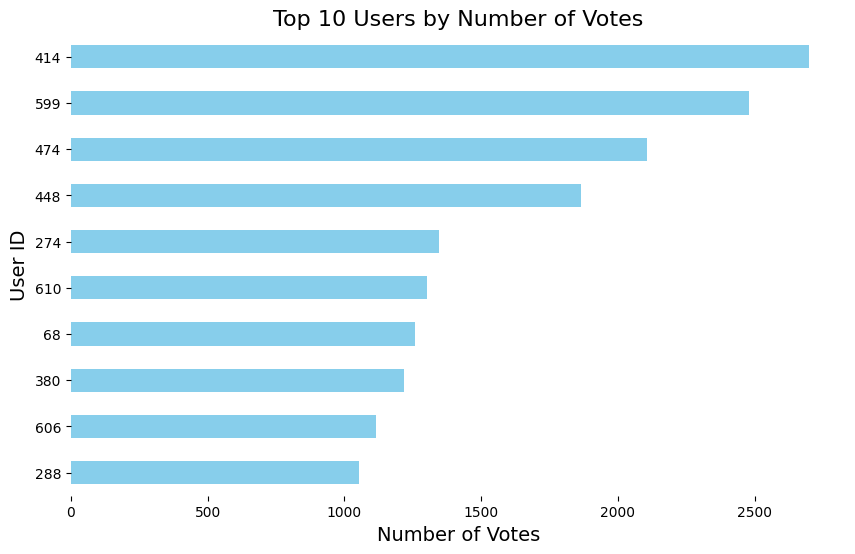

In [25]:
plt.figure(figsize=(10, 6))
count_userId.sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Users by Number of Votes', fontsize=16)
plt.xlabel('Number of Votes', fontsize=14)
plt.ylabel('User ID', fontsize=14)
plt.gca().invert_yaxis()
plt.box(None)
plt.show()

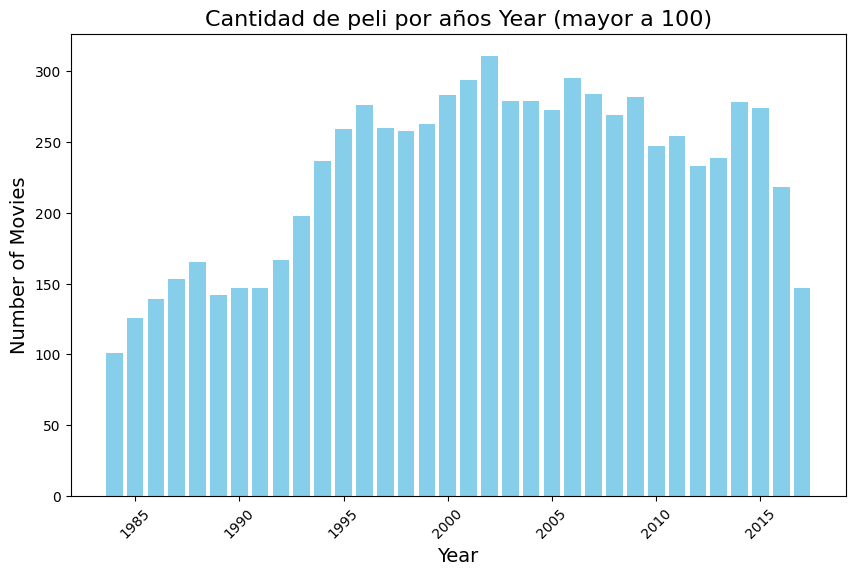

In [26]:
# Histograma del atributo 'years' en df_movies
movie_years=df_movies.groupby('year')['movieId'].count().reset_index()
movie_years=movie_years[movie_years['year']!=0]
movie_years=movie_years[movie_years['movieId']>=100]

plt.figure(figsize=(10, 6))
plt.bar(movie_years['year'], movie_years['movieId'], color='skyblue')

plt.title('Cantidad de peli por años Year (mayor a 100)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(rotation=45)
plt.show()

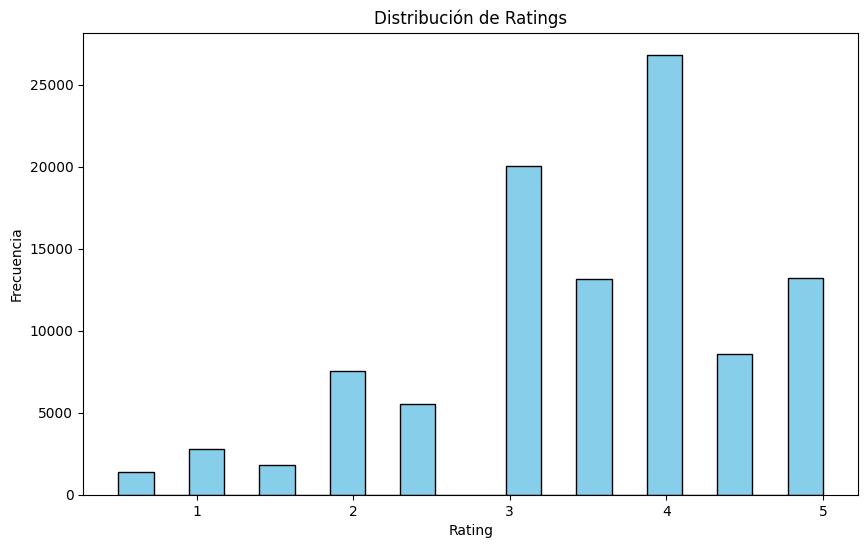

In [27]:
# Histograma del atributo 'rating' en df_ratings
plt.figure(figsize=(10, 6))
plt.hist(df_ratings['rating'], bins=20, edgecolor='black', color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()


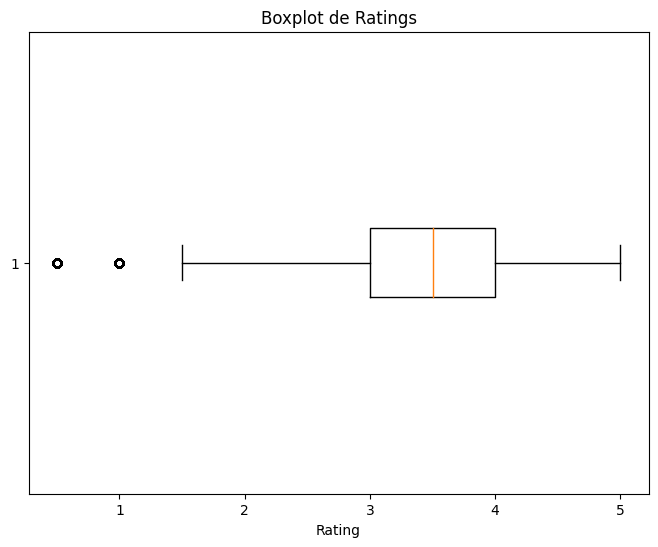

In [28]:
# Boxplot del atributo 'rating' en df_ratings
plt.figure(figsize=(8, 6))
plt.boxplot(df_ratings['rating'], vert=False)
plt.title('Boxplot de Ratings')
plt.xlabel('Rating')
plt.show()


In [29]:
len(df_movies[df_movies['genres']== "(no genres listed)"])

34

In [30]:
from collections import Counter # Contar la frecuencia de cada género en df_movies

df=df_movies[df_movies['genres']!= "(no genres listed)"]
genres = df['genres'].str.split('|').explode()
genre_counts = Counter(genres)

df_genres = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
total=df_genres['Count'].sum()
total

22050

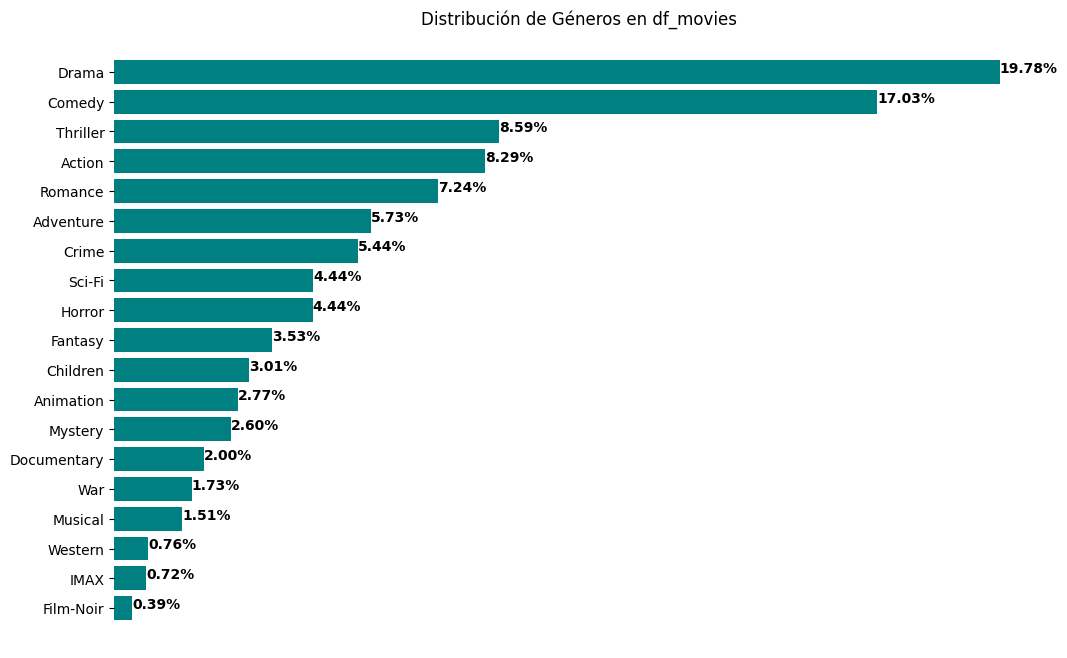

In [31]:
from collections import Counter # Contar la frecuencia de cada género en df_movies

genres = df['genres'].str.split('|').explode()
genre_counts = Counter(genres)
df_genres = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
df_genres.sort_values(by='Count', ascending=True, inplace=True)

plt.figure(figsize=(12, 8))
plt.barh(df_genres.index, df_genres.Count, color='teal')

for i, v in enumerate(df_genres.Count):
    plt.text(v, i, f'{v/total:.2%}', color='black', fontweight='bold')

plt.title('Distribución de Géneros en df_movies')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.box(False)
plt.show()


In [32]:
df_final = pd.merge(df_ratings, df_movies, on='movieId')
df_final = pd.merge(df_final, df_tags[['movieId','tag']], on='movieId')
df_final.dropna(inplace=True)
df_final.head()

userId  movieId  rating           timestamp      title  \
0       1        1    4.00 2000-07-30 18:45:03  Toy Story   
1       1        1    4.00 2000-07-30 18:45:03  Toy Story   
2       1        1    4.00 2000-07-30 18:45:03  Toy Story   
3       5        1    4.00 1996-11-08 06:36:02  Toy Story   
4       5        1    4.00 1996-11-08 06:36:02  Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1  Adventure|Animation|Children|Comedy|Fantasy   
2  Adventure|Animation|Children|Comedy|Fantasy   
3  Adventure|Animation|Children|Comedy|Fantasy   
4  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1  Adventure Animation Children Comedy Fantasy   
2  Adventure Animation Children Comedy Fantasy   
3  Adventure Animation Children Comedy Fantasy   
4  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year    tag  
0  {Adventure, Comedy, Fantasy, Children, Animation}  1995  pixar  
1  {Adventure, Comedy, Fantasy, Children, Animation}  1995  pixar  
2  {Adventure, Comedy, Fantasy, Children, Animation}  1995    fun  
3  {Adventure, Comedy, Fantasy, Children, Animation}  1995  pixar  
4  {Adventure, Comedy, Fantasy, Children, Animation}  1995  pixar

In [33]:
df_final.describe()

userId   movieId    rating                      timestamp      year
count 233213.00 233213.00 233213.00                         233213 233213.00
mean     309.69  12320.00      3.97  2008-06-15 10:00:05.688053248   1994.41
min        1.00      1.00      0.50            1996-03-29 18:36:55      0.00
25%      156.00    296.00      3.50            2002-03-29 01:16:06   1994.00
50%      309.00   1198.00      4.00            2008-07-29 09:45:57   1994.00
75%      460.00   4638.00      5.00            2015-09-25 17:11:10   2000.00
max      610.00 193565.00      5.00            2018-09-24 14:27:30   2018.00
std      178.21  28243.92      0.97                            NaN     13.73

In [34]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     233213 non-null  uint32        
 1   movieId    233213 non-null  uint32        
 2   rating     233213 non-null  float64       
 3   timestamp  233213 non-null  datetime64[ns]
 4   title      233213 non-null  object        
 5   genres     233213 non-null  object        
 6   content    233213 non-null  object        
 7   genre_set  233213 non-null  object        
 8   year       233213 non-null  uint16        
 9   tag        233213 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5), uint16(1), uint32(2)
memory usage: 14.7+ MB


In [35]:
df_title_count_votes = df_final.groupby('title')['userId'].count().reset_index().nlargest(10, 'userId')
df_title_count_votes.rename(columns={'userId': 'count_votes'}, inplace=True)
df_title_count_votes

title  count_votes
1071                                       Pulp Fiction        55567
437                                          Fight Club        11772
1290                 Star Wars: Episode IV - A New Hope         6526
802   Léon: The Professional (a.k.a. The Professiona...         4655
10                                2001: A Space Odyssey         4469
401               Eternal Sunshine of the Spotless Mind         4454
656                                           Inception         3718
146                                   Big Lebowski, The         3392
364                                        Donnie Darko         3161
458                                        Forrest Gump         2961

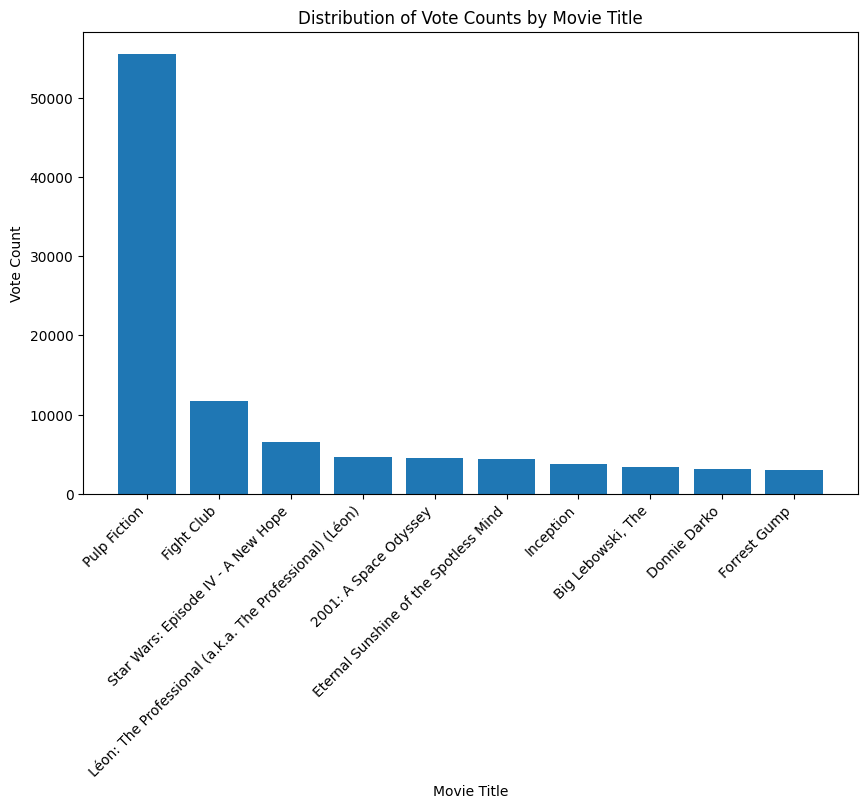

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(df_title_count_votes['title'], df_title_count_votes['count_votes'])
plt.xlabel('Movie Title')
plt.ylabel('Vote Count')
plt.title('Distribution of Vote Counts by Movie Title')
plt.xticks(rotation=45, ha='right')
plt.show()

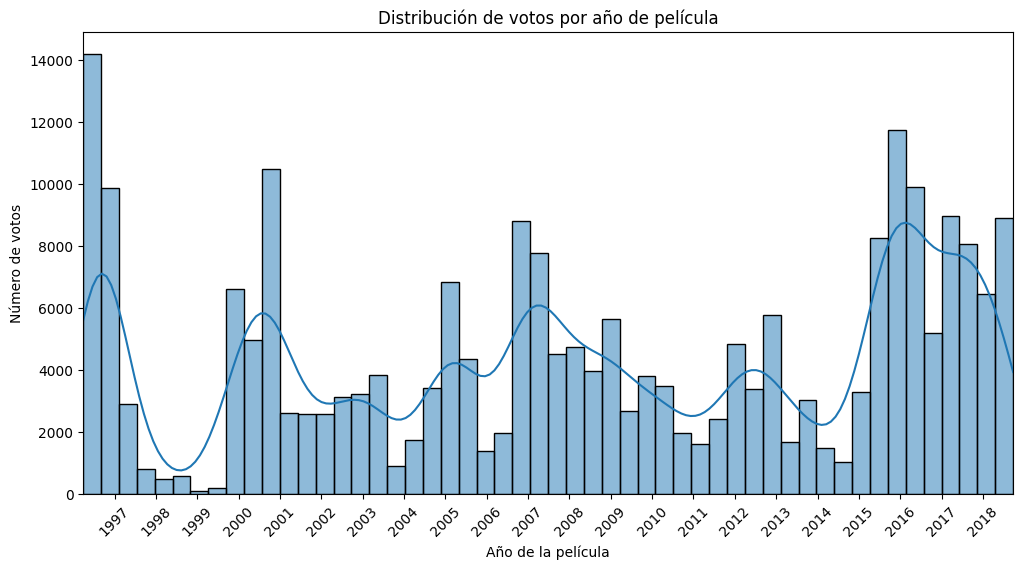

In [37]:
### Distribución de votos por año de película
df=df_final.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='timestamp', kde=True)
plt.title('Distribución de votos por año de película')
plt.xlabel('Año de la película')
plt.ylabel('Número de votos')
years = df['timestamp'].dt.year.unique()
plt.xticks(ticks=pd.to_datetime(years, format='%Y'), labels=years,rotation=45)
plt.xlim(df['timestamp'].min(),df['timestamp'].max())
plt.show()

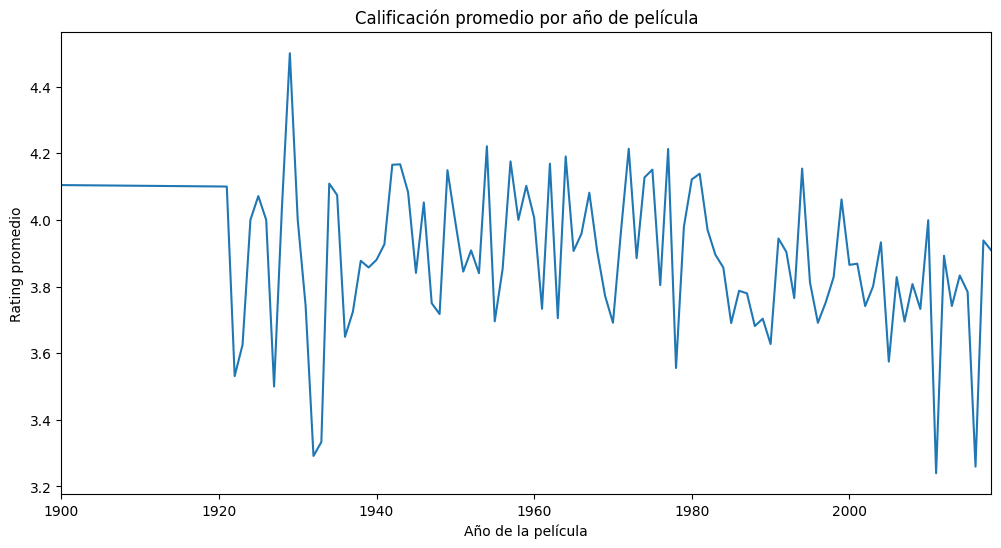

In [38]:
### Rating promedio por año de película
df=df_final.copy()
yearly_ratings = df.groupby('year')['rating'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_ratings, x='year', y='rating')
plt.title('Calificación promedio por año de película')
plt.xlabel('Año de la película')
plt.ylabel('Rating promedio')
plt.xlim(1900,df['year'].max())
plt.show()

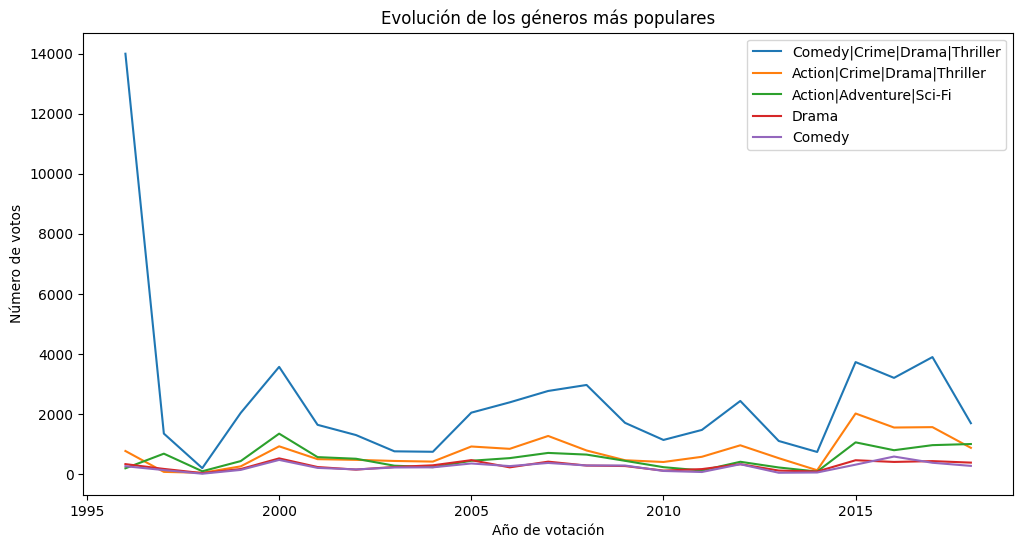

In [39]:
### Evolución de los géneros más populares a lo largo del tiempo
df=df_final.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['vote_year'] = df['timestamp'].dt.year
genre_popularity = df.groupby(['vote_year', 'genres']).size().reset_index(name='count')
top_genres = genre_popularity.groupby('genres')['count'].sum().nlargest(5).index

plt.figure(figsize=(12, 6))
for genre in top_genres:
    genre_data = genre_popularity[genre_popularity['genres'] == genre]
    plt.plot(genre_data['vote_year'], genre_data['count'], label=genre)

plt.title('Evolución de los géneros más populares')
plt.xlabel('Año de votación')
plt.ylabel('Número de votos')
plt.legend()
plt.show()

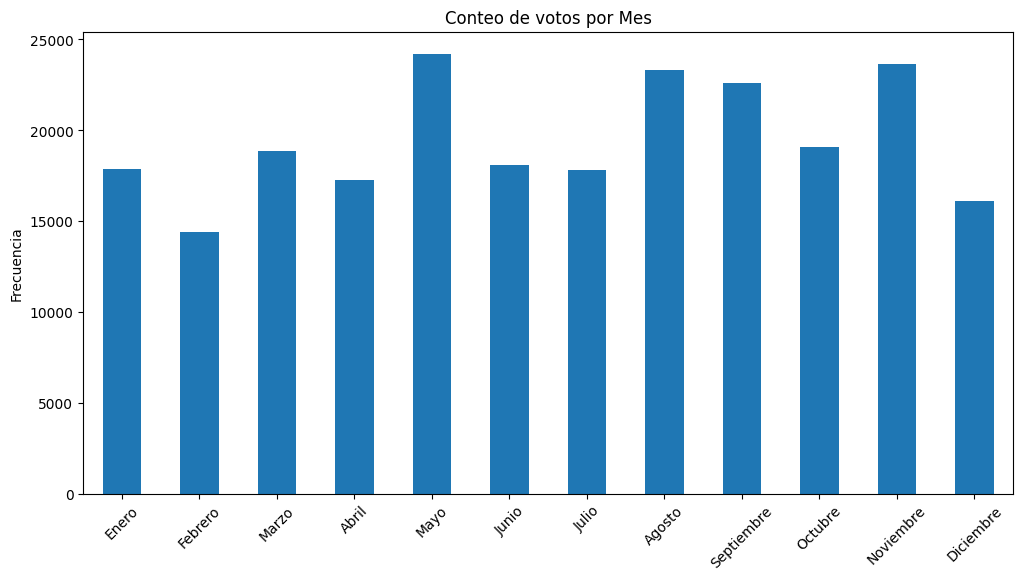

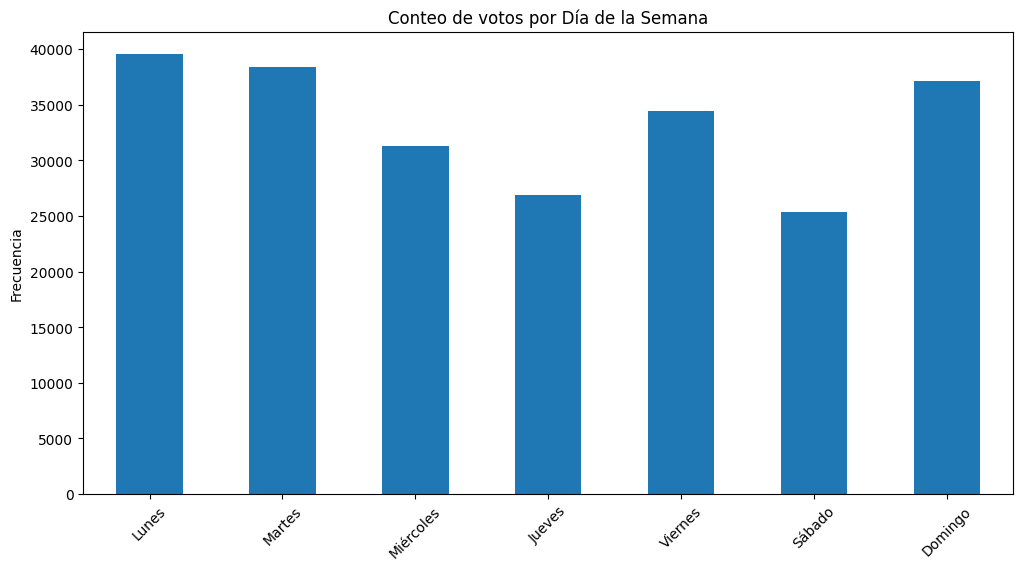

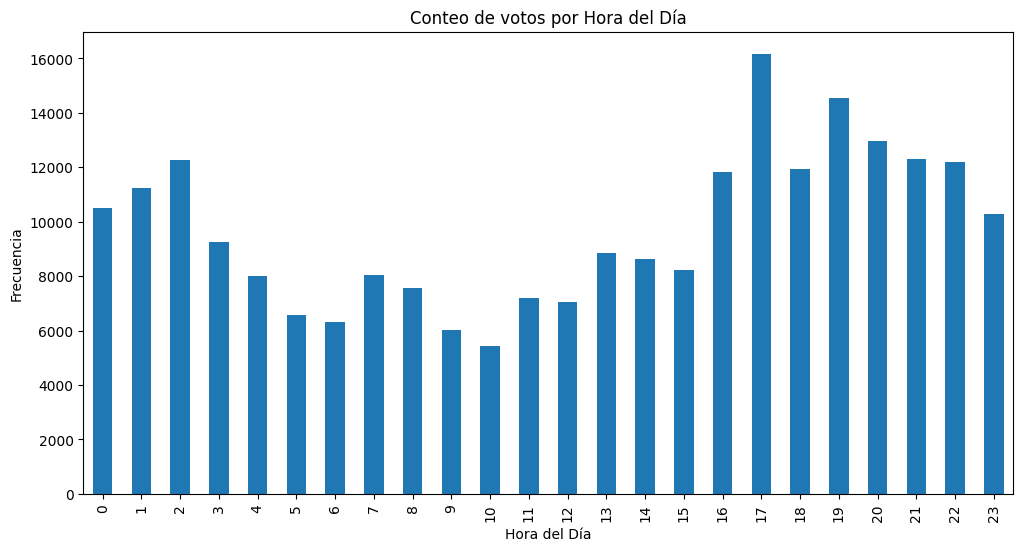

In [40]:
df=df_final.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

# Análisis por mes
monthly_ratings = df.groupby('month')['rating'].count()
plt.figure(figsize=(12, 6))
monthly_ratings.plot(kind='bar')
plt.title('Conteo de votos por Mes')
plt.xticks(range(0, 12), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],rotation=45)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.show()

# Análisis por día de la semana
daily_ratings = df.groupby('day_of_week')['rating'].count()
plt.figure(figsize=(12, 6))
daily_ratings.plot(kind='bar')
plt.title('Conteo de votos por Día de la Semana')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'],rotation=45)
plt.ylabel('Frecuencia')
plt.xlabel('')

plt.show()

# Análisis por hora
hourly_ratings = df.groupby('hour')['rating'].count()
plt.figure(figsize=(12, 6))
hourly_ratings.plot(kind='bar')
plt.title('Conteo de votos por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Frecuencia')
plt.show()

In [41]:
#agrupar por title con promedio de rating:

df_title_rating = df_final.groupby('title')['rating'].mean().reset_index()
df_title_rating.rename(columns={'rating': 'mean_rating'}, inplace=True)
df_title_rating.sort_values(by='mean_rating', ascending=False, inplace=True)
df_title_rating.sample(10)

title  mean_rating
90               Arsenic and Old Lace         3.88
1358  The Importance of Being Earnest         4.33
1475                    Waterboy, The         3.18
385               Edward Scissorhands         3.70
1070                           Psycho         4.04
1112                  Renaissance Man         3.06
257                    Cinderella Man         4.09
580                          Heathers         3.73
366                  Double Indemnity         4.32
124                    Beat the Devil         3.50

#**3. Estrategias de Recomendación**


---




##**3.1 Recomendación no personalizada**

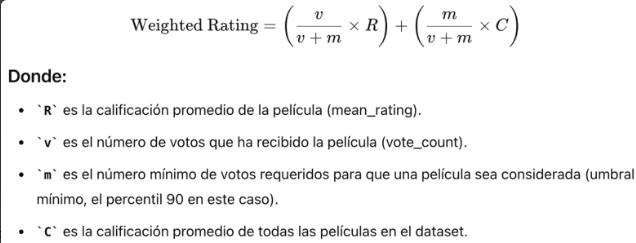

In [42]:
col=['userId', 'movieId', 'rating', 'timestamp', 'title',
       'content', 'year']
df_all=df_final[col].rename(columns={'content':'genres'})
df_all.sample(3)

userId  movieId  rating           timestamp  \
10928      469      260    4.00 2000-08-03 20:14:26   
223827     508      562    2.50 2010-03-11 08:52:17   
207812     517   116797    4.00 2017-04-16 10:35:57   

                                     title                   genres  year  
10928   Star Wars: Episode IV - A New Hope  Action Adventure Sci-Fi  1977  
223827            Welcome to the Dollhouse             Comedy Drama  1995  
207812                  The Imitation Game       Drama Thriller War  2014

In [43]:
df_final.head(1)

userId  movieId  rating           timestamp      title  \
0       1        1    4.00 2000-07-30 18:45:03  Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year    tag  
0  {Adventure, Comedy, Fantasy, Children, Animation}  1995  pixar

In [44]:
def recomendacion_populares():
    vote_counts = df_final['title'].value_counts()
    df_popular_movies = df_final[df_final['title'].isin(vote_counts[vote_counts > 210].index)]
    df_movie_stats = df_popular_movies.groupby(['title','movieId','year']).agg(
        mean_rating=('rating', 'mean'),
        vote_count=('title', 'count')
    ).reset_index()

    m = df_movie_stats['vote_count'].quantile(.9) # Calcular el número mínimo de votos requeridos (m)
    C = df_final['rating'].mean()  # Calcular la calificación promedio de todas las películas (C)
    df_movie_stats['bayesian_average'] = (df_movie_stats['vote_count'] / (df_movie_stats['vote_count'] + m)) * df_movie_stats['mean_rating'] + (m / (df_movie_stats['vote_count'] + m)) * C
    df_movie_stats = df_movie_stats.nlargest(10, 'bayesian_average')
    return df_movie_stats

In [45]:
recomendacion_populares= recomendacion_populares()
df_poster_pop = pd.merge(recomendacion_populares, df_poster, on='movieId', how='left')
df_poster_pop

title  movieId  year  \
0                                         Fight Club     2959  1999   
1                                       Pulp Fiction      296  1994   
2                 Star Wars: Episode IV - A New Hope      260  1977   
3                          Shawshank Redemption, The      318  1994   
4              Eternal Sunshine of the Spotless Mind     7361  2004   
5     Star Wars: Episode V - The Empire Strikes Back     1196  1980   
6                                       Forrest Gump      356  1994   
7                                   Schindler's List      527  1993   
8  Raiders of the Lost Ark (Indiana Jones and the...     1198  1981   
9                                Usual Suspects, The       50  1995   

   mean_rating  vote_count  bayesian_average    imdb_id  \
0         4.27       11772              4.23  tt0137523   
1         4.20       55567              4.19  tt0110912   
2         4.23        6526              4.17  tt0076759   
3         4.43        1268              4.16  tt0111161   
4         4.16        4454              4.11  tt0338013   
5         4.22        2110              4.10  tt0080684   
6         4.16        2961              4.09  tt0109830   
7         4.22        1540              4.09  tt0108052   
8         4.21        1600              4.08  tt0082971   
9         4.24        1224              4.08  tt0114814   

                        poster_path  
0  /pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg  
1  /d5iIlFn5s0ImszYzBPb8JPIfbXD.jpg  
2  /6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg  
3  /lyQBXzOQSuE59IsHyhrp0qIiPAz.jpg  
4  /5MwkWH9tYHv3mV9OdYTMR5qreIz.jpg  
5  /nNAeTmF4CtdSgMDplXTDPOpYzsX.jpg  
6  /arw2vcBveWOVZr6pxd9XTd1TdQa.jpg  
7  /sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg  
8  /ceG9VzoRAVGwivFU403Wc3AHRys.jpg  
9  /bUPmtQzrRhzqYySeiMpv7GurAfm.jpg

In [46]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233213 entries, 0 to 233212
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     233213 non-null  uint32        
 1   movieId    233213 non-null  uint32        
 2   rating     233213 non-null  float64       
 3   timestamp  233213 non-null  datetime64[ns]
 4   title      233213 non-null  object        
 5   genres     233213 non-null  object        
 6   content    233213 non-null  object        
 7   genre_set  233213 non-null  object        
 8   year       233213 non-null  uint16        
 9   tag        233213 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5), uint16(1), uint32(2)
memory usage: 14.7+ MB


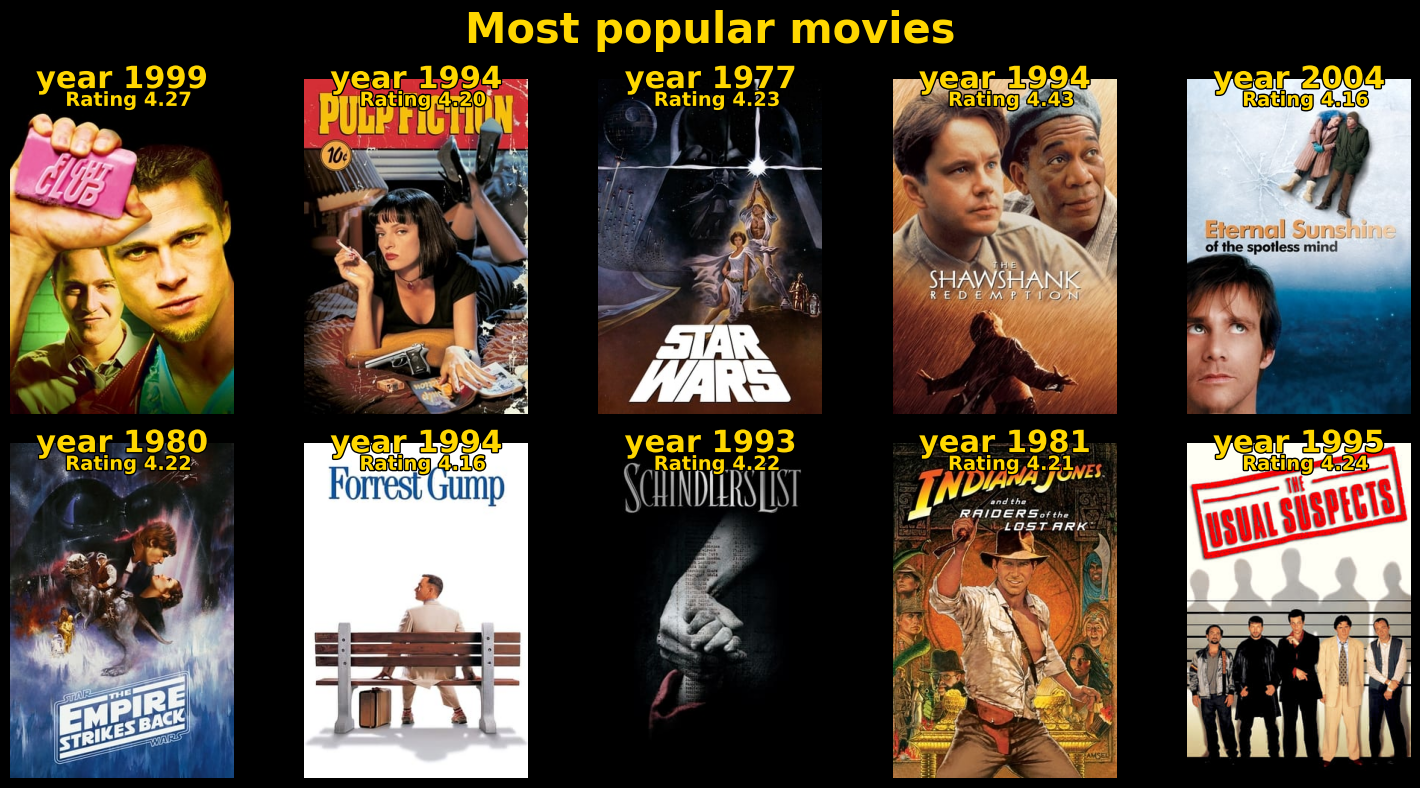

In [47]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

df_poster_pop['poster_path'] = df_poster_pop['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df_poster_pop.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df_poster_pop['year'], df_poster_pop['mean_rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Most popular movies', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

##**3.2 Recomendación Content-Based**

###**3.2.1 Similitud de Jaccard**

In [48]:
def similitud_jaccard(set1, set2):
    """Calcula la similitud de Jaccard entre dos conjuntos."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def recomendacion_jaccard(movie_id, df, n_recommendations=10):
    input_features = df[df['movieId'] == movie_id]['genre_set'].values[0]
    df['similaridad'] = df['genre_set'].apply(lambda x: similitud_jaccard(input_features, x))
    df.sort_values('similaridad', ascending=False, inplace=True)
    df=df.nlargest(n_recommendations,'similaridad')
    df.sort_values('year', ascending=False, inplace=True)
    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_jaccard = pd.merge(df, df_average_ratings, on='movieId', how='left')
    return df_poster_jaccard


In [49]:
movieId=1
# movieId=58559
recomendaciones_jaccard = recomendacion_jaccard(movieId, df_movies, n_recommendations=10)
df_poster_jaccard = pd.merge(recomendaciones_jaccard, df_poster, on='movieId', how='left')
df_poster_jaccard

movieId                                    title  \
0   166461                                    Moana   
1   136016                        The Good Dinosaur   
2   103755                                    Turbo   
3    65577                  Tale of Despereaux, The   
4    45074                                Wild, The   
5     4886                           Monsters, Inc.   
6     3754  Adventures of Rocky and Bullwinkle, The   
7     4016                Emperor's New Groove, The   
8     2294                                     Antz   
9        1                                Toy Story   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1  Adventure|Animation|Children|Comedy|Fantasy   
2  Adventure|Animation|Children|Comedy|Fantasy   
3  Adventure|Animation|Children|Comedy|Fantasy   
4  Adventure|Animation|Children|Comedy|Fantasy   
5  Adventure|Animation|Children|Comedy|Fantasy   
6  Adventure|Animation|Children|Comedy|Fantasy   
7  Adventure|Animation|Children|Comedy|Fantasy   
8  Adventure|Animation|Children|Comedy|Fantasy   
9  Adventure|Animation|Children|Comedy|Fantasy   

                                       content  \
0  Adventure Animation Children Comedy Fantasy   
1  Adventure Animation Children Comedy Fantasy   
2  Adventure Animation Children Comedy Fantasy   
3  Adventure Animation Children Comedy Fantasy   
4  Adventure Animation Children Comedy Fantasy   
5  Adventure Animation Children Comedy Fantasy   
6  Adventure Animation Children Comedy Fantasy   
7  Adventure Animation Children Comedy Fantasy   
8  Adventure Animation Children Comedy Fantasy   
9  Adventure Animation Children Comedy Fantasy   

                                           genre_set  year  similaridad  \
0  {Adventure, Comedy, Fantasy, Children, Animation}  2016         1.00   
1  {Adventure, Comedy, Fantasy, Children, Animation}  2015         1.00   
2  {Adventure, Comedy, Fantasy, Children, Animation}  2013         1.00   
3  {Adventure, Comedy, Fantasy, Children, Animation}  2008         1.00   
4  {Adventure, Comedy, Fantasy, Children, Animation}  2006         1.00   
5  {Adventure, Comedy, Fantasy, Children, Animation}  2001         1.00   
6  {Adventure, Comedy, Fantasy, Children, Animation}  2000         1.00   
7  {Adventure, Comedy, Fantasy, Children, Animation}  2000         1.00   
8  {Adventure, Comedy, Fantasy, Children, Animation}  1998         1.00   
9  {Adventure, Comedy, Fantasy, Children, Animation}  1995         1.00   

   rating    imdb_id                       poster_path  
0    3.45  tt3521164  /vNJFiwtsl7Twww7C0uM4qPnygNw.jpg  
1    3.00  tt1979388  /8RSkxOO80btfKjyiC5ZiTaCHIT8.jpg  
2    2.50  tt1860353  /inTKQni4YW8syrfgnXHwzmNeSo4.jpg  
3    3.00  tt0420238  /6bBzgQ1uJabDHeGR9QvKrHvHYzG.jpg  
4    2.50  tt0405469  /sxqzaOto1qyUseSg6YpIP9Su5lp.jpg  
5    3.87  tt0198781  /sgheSKxZkttIe8ONsf2sWXPgip3.jpg  
6    2.22  tt0131704  /xCFSsftt2rglC81I6QLWcZSTCBM.jpg  
7    3.72  tt0120917  /wwbgkXQBEKtnyIJapk6gUgWkVw8.jpg  
8    3.24  tt0120587  /lWPjxbUMpAHFkJpZHHNWhQaRsax.jpg  
9    3.92  tt0114709  /uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg

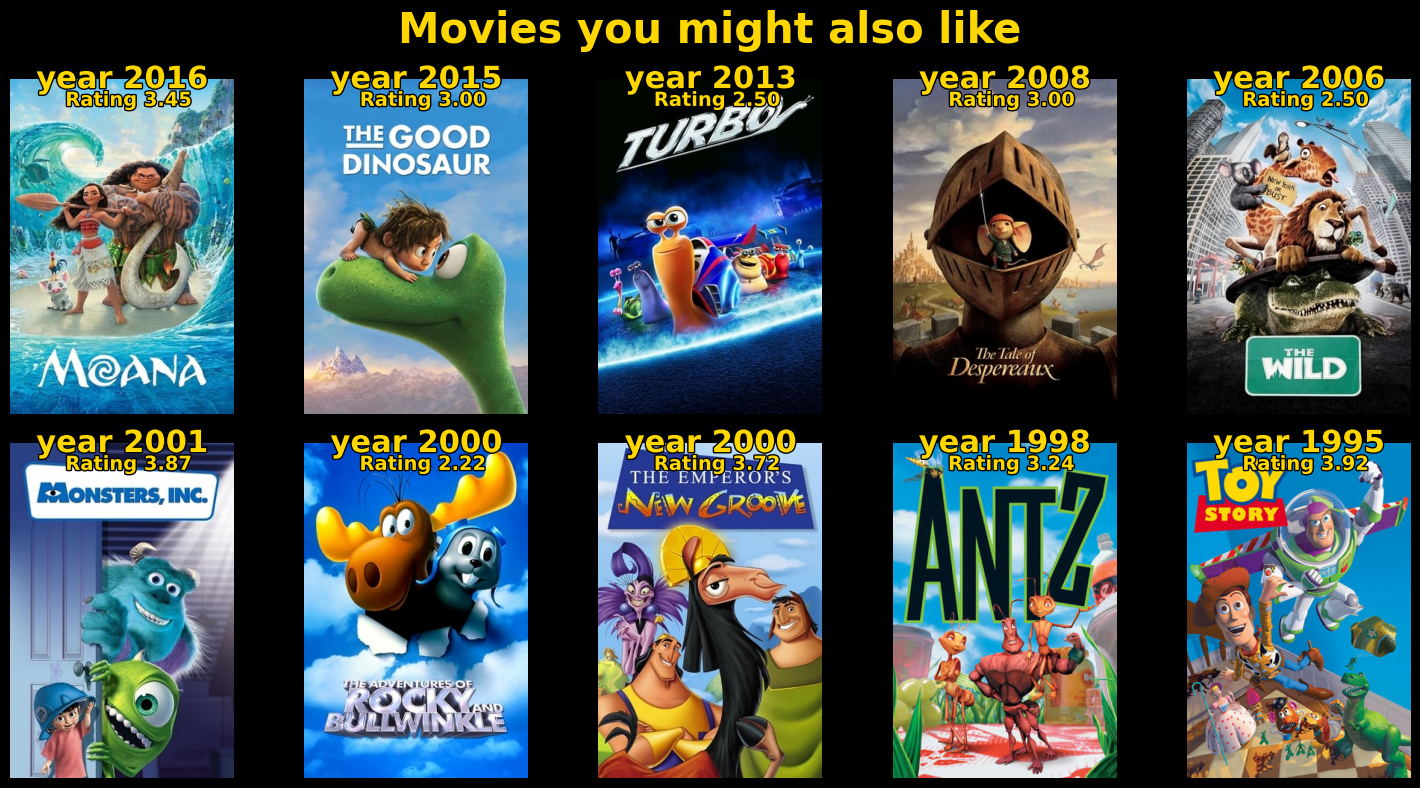

In [50]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO
df=df_poster_jaccard.copy()
df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Movies you might also like', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

###**3.2.2 Similitud de Coseno con TF-IDF**

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')
feature_vectors = vectorizer.fit_transform(df_movies['content'])
cosine_sim = cosine_similarity(feature_vectors,feature_vectors)

In [52]:
def recomendacion_tf_idf(movie_id, df_movies,df_ratings, cosine_sim, n_recommendations=10):
    idx = df_movies[df_movies['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [x for x in sim_scores if x[0] != idx]
    movie_indices = [x[0] for x in sim_scores[:n_recommendations]]
    recommended_movies = df_movies.iloc[movie_indices]
    recommended_movies = recommended_movies.copy()
    recommended_movies['distance'] = [x[1] for x in sim_scores[:n_recommendations]]
    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_tfidfvec = pd.merge(recommended_movies, df_average_ratings, on='movieId', how='left')
    df_poster_tfidfvec.drop(['genres','genre_set','similaridad'], axis=1,inplace=True)
    return df_poster_tfidfvec

In [53]:
movieId=1
# movieId=58559
recomendaciones_tfidf = recomendacion_tf_idf(movieId, df_movies,df_ratings, cosine_sim, n_recommendations=10)
recomendaciones_tfidf = pd.merge(recomendaciones_tfidf, df_poster, on='movieId', how='left')
recomendaciones_tfidf

movieId                                             title  \
0    45074                                         Wild, The   
1     2294                                              Antz   
2   166461                                             Moana   
3   103755                                             Turbo   
4    65577                           Tale of Despereaux, The   
5     3754           Adventures of Rocky and Bullwinkle, The   
6   136016                                 The Good Dinosaur   
7     4886                                    Monsters, Inc.   
8     4016                         Emperor's New Groove, The   
9    91355  Asterix and the Vikings (Astérix et les Vikings)   

                                       content  year  distance  rating  \
0  Adventure Animation Children Comedy Fantasy  2006      1.00    2.50   
1  Adventure Animation Children Comedy Fantasy  1998      1.00    3.24   
2  Adventure Animation Children Comedy Fantasy  2016      1.00    3.45   
3  Adventure Animation Children Comedy Fantasy  2013      1.00    2.50   
4  Adventure Animation Children Comedy Fantasy  2008      1.00    3.00   
5  Adventure Animation Children Comedy Fantasy  2000      1.00    2.22   
6  Adventure Animation Children Comedy Fantasy  2015      1.00    3.00   
7  Adventure Animation Children Comedy Fantasy  2001      1.00    3.87   
8  Adventure Animation Children Comedy Fantasy  2000      1.00    3.72   
9  Adventure Animation Children Comedy Fantasy  2006      1.00    5.00   

     imdb_id                       poster_path  
0  tt0405469  /sxqzaOto1qyUseSg6YpIP9Su5lp.jpg  
1  tt0120587  /lWPjxbUMpAHFkJpZHHNWhQaRsax.jpg  
2  tt3521164  /vNJFiwtsl7Twww7C0uM4qPnygNw.jpg  
3  tt1860353  /inTKQni4YW8syrfgnXHwzmNeSo4.jpg  
4  tt0420238  /6bBzgQ1uJabDHeGR9QvKrHvHYzG.jpg  
5  tt0131704  /xCFSsftt2rglC81I6QLWcZSTCBM.jpg  
6  tt1979388  /8RSkxOO80btfKjyiC5ZiTaCHIT8.jpg  
7  tt0198781  /sgheSKxZkttIe8ONsf2sWXPgip3.jpg  
8  tt0120917  /wwbgkXQBEKtnyIJapk6gUgWkVw8.jpg  
9  tt0371552  /dW9h1Ez6PRx8PnZUVT27MnG8Wu5.jpg

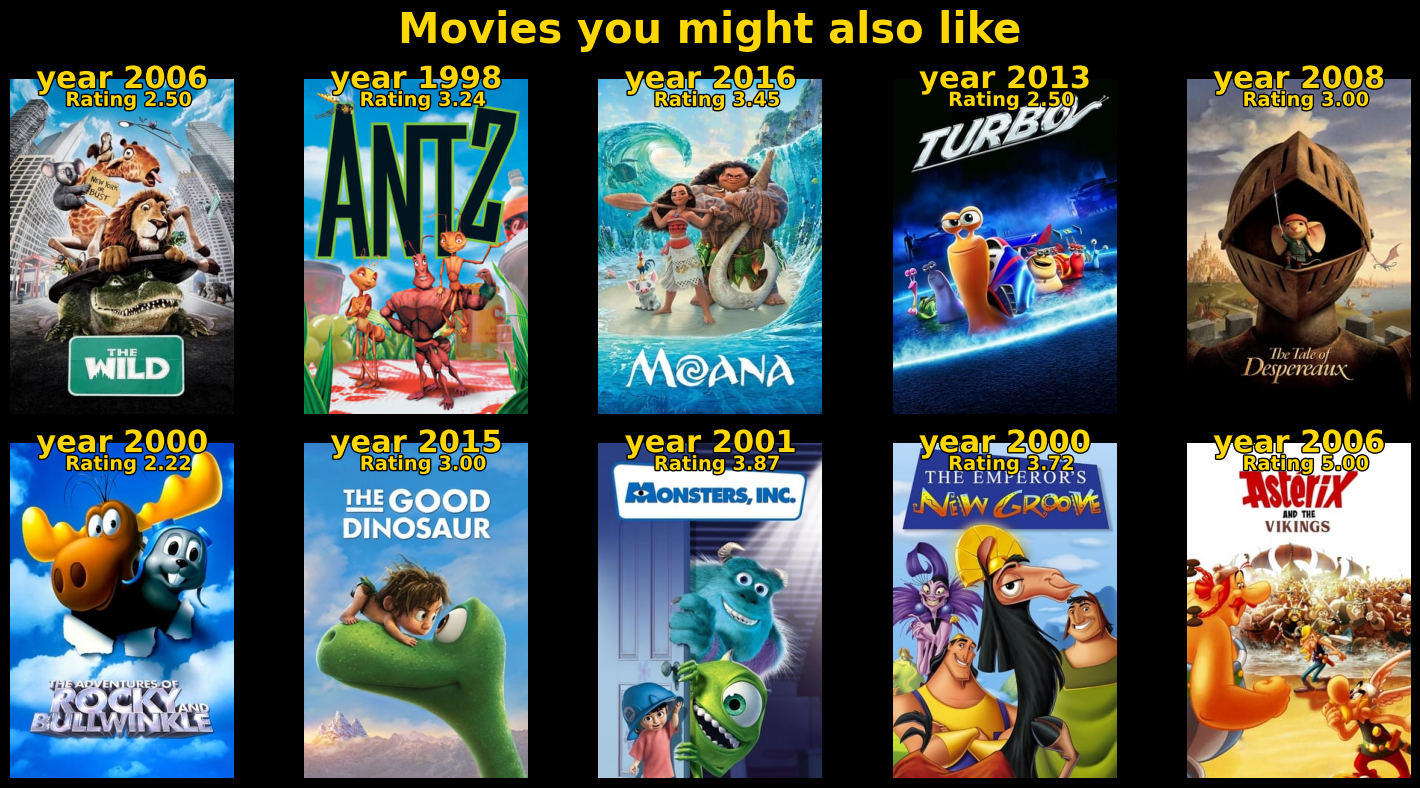

In [54]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

df=recomendaciones_tfidf.copy()
df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

image_urls = list(df.poster_path)

fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
    ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                             path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

fig.suptitle(f'Movies you might also like', fontsize=30, color='gold', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

##**3.3 Recomendación Collaborative Filtering**

In [278]:
#importar NearestNeighbors:
from sklearn.neighbors import NearestNeighbors

df=df_final.copy()
df_agg = df.groupby(['userId', 'movieId'])['rating'].mean().reset_index()
print(df_agg.userId.max())
ratings_matrix = df_agg.pivot(index='userId', columns='movieId', values='rating')
avg_ratings = ratings_matrix.mean(axis=1, skipna=True)
ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(ratings_matrix_normalized.values)

610


NearestNeighbors(algorithm='brute', metric='cosine')

In [305]:
def recomendacion_knn(user_input, df_final,df_ratings,df_agg, ratings_matrix_normalized,knn_model, n_recommendations=10):
    if isinstance(user_input, int):
        print('Existing user')
        print(df_agg.userId.max())
        df_agg = df_final.groupby(['userId', 'movieId'])['rating'].mean().reset_index()
        print(df_agg.userId.max())
        ratings_matrix = df_agg.pivot(index='userId', columns='movieId', values='rating')
        avg_ratings = ratings_matrix.mean(axis=1, skipna=True)
        ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
        knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
        knn_model.fit(ratings_matrix_normalized.values)
        idx = ratings_matrix_normalized.index.get_loc(user_input)
        distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    else:
        print('New user')
        print(df_agg.userId.max())

        new_user_ratings = pd.DataFrame({
        'userId': [df_agg['userId'].max() + 1] * 2,
        'movieId': usuario.index,
        'rating': usuario.values})

        df_agg = pd.concat([df_agg, new_user_ratings], ignore_index=True)
        # print(df_agg.tail(3))
        ratings_matrix = df_agg.pivot(index='userId', columns='movieId', values='rating')
        avg_ratings = ratings_matrix.mean(axis=1, skipna=True)
        ratings_matrix_normalized = ratings_matrix.sub(avg_ratings, axis=0).fillna(0)
        knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
        knn_model.fit(ratings_matrix_normalized.values)
        idx = ratings_matrix_normalized.index.get_loc(df_agg.userId.max())
        distances, indices = knn_model.kneighbors(ratings_matrix_normalized.iloc[idx].values.reshape(1, -1), n_neighbors=n_recommendations + 1)

    distances = distances.flatten()[1:]
    indices = indices.flatten()[1:]

    similar_users = ratings_matrix_normalized.iloc[indices]

    mean_ratings = similar_users.T.dot(distances) / np.sum(distances)
    df_mean_ratings = pd.DataFrame(mean_ratings, index=ratings_matrix_normalized.columns, columns=['mean_rating'])
    df_mean_ratings = df_mean_ratings.dropna()

    ### Filtrar peli ya vistas por el user:
    if isinstance(user_input, int):
        movies_seen = df_final[df_final['userId']==user_input].index
        df_mean_ratings = df_mean_ratings[~df_mean_ratings.index.isin(movies_seen)]
    else:
        movies_seen = df_agg[df_agg['userId'] == df_agg['userId'].max()]['movieId']
        df_mean_ratings = df_mean_ratings[~df_mean_ratings.index.isin(movies_seen)]
        print('last user: ',df_agg.userId.max())

    df_mean_ratings = df_mean_ratings.sort_values('mean_rating', ascending=False)

    recommended_movies = pd.merge(df_mean_ratings, df_final[['movieId', 'title', 'content','year']], left_index=True, right_on='movieId')
    recommended_movies.drop_duplicates(subset=['movieId'], inplace=True)
    columnas=['movieId', 'title', 'content','mean_rating','year']
    recommended_movies=recommended_movies[columnas].head(n_recommendations)

    df_average_ratings=df_ratings.groupby('movieId')['rating'].mean().reset_index()
    df_poster_knn = pd.merge(recommended_movies, df_average_ratings, on='movieId', how='left')
    return df_poster_knn

In [291]:
movies_seen = df_final[df_final['userId'] == 611]['movieId']
movies_seen

Series([], Name: movieId, dtype: uint32)

In [242]:
from PIL import Image
import requests
import matplotlib.patheffects as patheffects
from io import BytesIO

def graf_poster(df):
    df['poster_path'] = df['poster_path'].apply(lambda x: f"{path_img}{x}")

    image_urls = list(df.poster_path)

    fig, axes = plt.subplots(2, 5, figsize=(15, 8), facecolor='black', sharex=True, sharey=True)

    for idx, (ax, img_url,year,averageRating) in enumerate(zip(axes.flatten(), image_urls, df['year'], df['rating']), start=1):
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content))
        ax.imshow(img)
        ax.axis('off')
        ax.text(150, 0, f'year {year}', color='gold', fontsize=22, ha='center', va='center', fontweight='bold',
                                path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])
        ax.text(159, 28, f'Rating {averageRating:.2f}', color='gold', fontsize=14, ha='center', va='center', fontweight='bold',
                                path_effects=[patheffects.withStroke(linewidth=2, foreground='black')])

    fig.suptitle("Movies we think you'll love", fontsize=30, color='gold', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 1])
    # plt.savefig(f'/content/drive/MyDrive/Bootcamp-Alejo-projects/Movie_Analysis/graficas/movie_pop.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

In [306]:
usuario = pd.Series({
    356: 4,
    58559: 5
})
# usuario = pd.Series({
#     1: 4,
#     23: 5
# })
usuario=15
recomendacion_knn = recomendacion_knn(usuario,df_final,df_ratings,df_agg, ratings_matrix_normalized,knn_model, n_recommendations=10)
recomendacion_knn = pd.merge(recomendacion_knn, df_poster, on='movieId', how='left')
recomendacion_knn

Existing user
610
610


movieId                                           title  \
0     1210      Star Wars: Episode VI - Return of the Jedi   
1      260              Star Wars: Episode IV - A New Hope   
2     2571                                     Matrix, The   
3      318                       Shawshank Redemption, The   
4     3578                                       Gladiator   
5     1196  Star Wars: Episode V - The Empire Strikes Back   
6      356                                    Forrest Gump   
7     1221                         Godfather: Part II, The   
8     7153  Lord of the Rings: The Return of the King, The   
9      593                       Silence of the Lambs, The   

                          content  mean_rating  year  rating    imdb_id  \
0         Action Adventure Sci-Fi         0.48  1983    4.14  tt0086190   
1         Action Adventure Sci-Fi         0.48  1977    4.23  tt0076759   
2          Action Sci-Fi Thriller         0.46  1999    4.19  tt0133093   
3                     Crime Drama         0.36  1994    4.43  tt0111161   
4          Action Adventure Drama         0.35  2000    3.94  tt0172495   
5         Action Adventure Sci-Fi         0.35  1980    4.22  tt0080684   
6        Comedy Drama Romance War         0.28  1994    4.16  tt0109830   
7                     Crime Drama         0.27  1974    4.26  tt0071562   
8  Action Adventure Drama Fantasy         0.26  2003    4.12  tt0167260   
9           Crime Horror Thriller         0.24  1991    4.16  tt0102926   

                        poster_path  
0  /jQYlydvHm3kUix1f8prMucrplhm.jpg  
1  /6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg  
2  /f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg  
3  /lyQBXzOQSuE59IsHyhrp0qIiPAz.jpg  
4  /ty8TGRuvJLPUmAR1H1nRIsgwvim.jpg  
5  /nNAeTmF4CtdSgMDplXTDPOpYzsX.jpg  
6  /arw2vcBveWOVZr6pxd9XTd1TdQa.jpg  
7  /hek3koDUyRQk7FIhPXsa6mT2Zc3.jpg  
8  /rCzpDGLbOoPwLjy3OAm5NUPOTrC.jpg  
9  /uS9m8OBk1A8eM9I042bx8XXpqAq.jpg

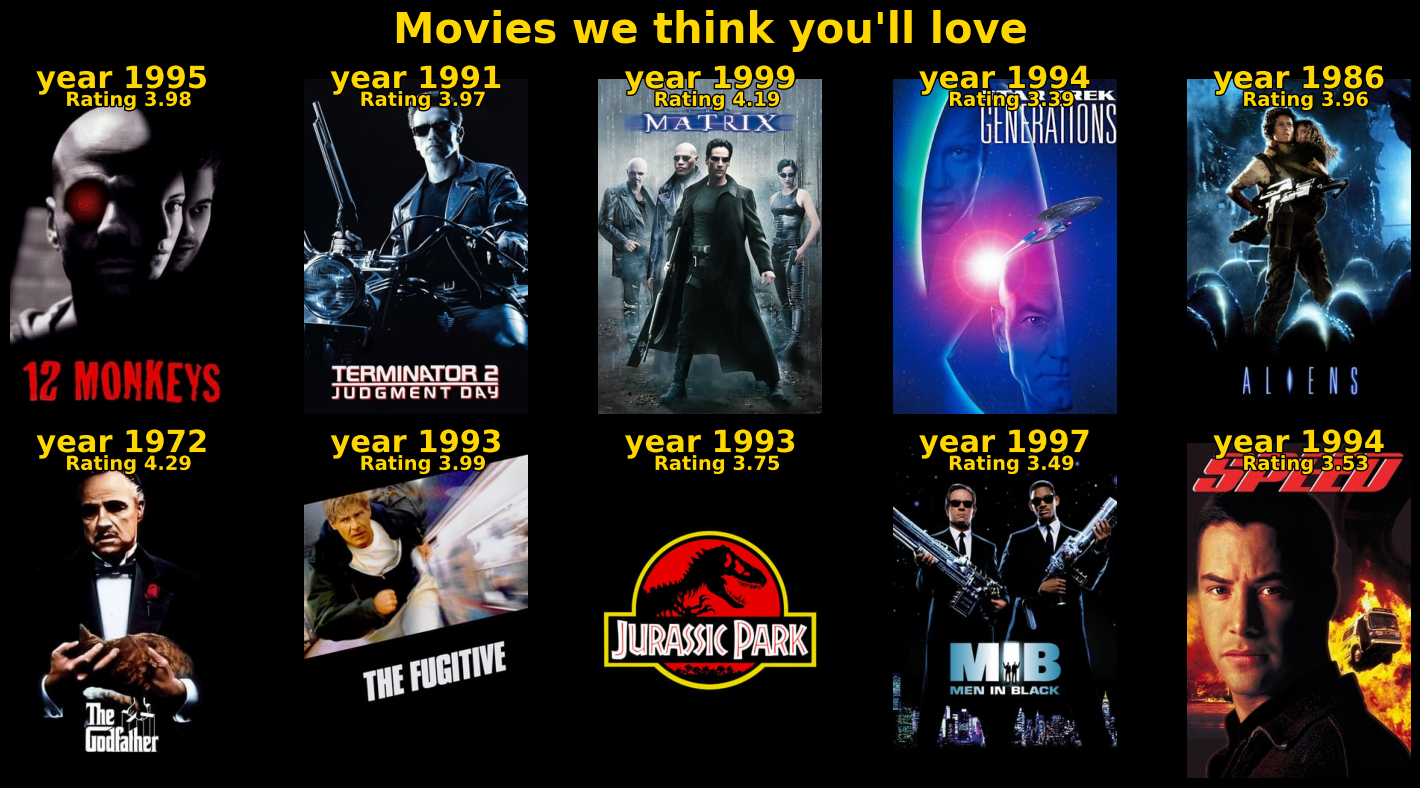

In [301]:
graf_poster(recomendacion_knn)

In [62]:
#@title
# def recomendacion_knn(usuario_id_o_ratings, ratings_matrix_normalized, ratings_matrix, df_movies, knn_model, n_recommendations=10):
#   #Tu código aquí
#   return recommendations


In [307]:
# from sklearn.preprocessing import LabelEncoder
# from tqdm import tqdm

# data = df_final.copy()

# # Definir la función para verificar si el género está presente
# def fill_genre(value, col):
#     return 1 if col in value.lower() else 0

# # Lista de géneros (asumo que 'genres' es una lista de géneros)
# # genres = ['action', 'comedy', 'drama', 'thriller', 'horror']  # Ajusta según tus géneros
# genres = data['content'].str.lower().str.split(',').explode().unique()
# # Crear columnas para cada género
# for col in genres:
#     data[col] = data['content'].apply(lambda x: fill_genre(x, col))

# # Eliminar columnas innecesarias
# data.drop(['tconst', 'release_date', 'genres', 'originalTitle','titleType','primaryTitle','production_companies','original_title','adult','production_countries','backdrop_path','backdrop_path','original_language','poster_path'], axis=1, inplace=True)

# # Aplicar LabelEncoder en la columna 'keywords'
# data['keywords'] = data['keywords'].fillna('')  # Asegurarse de que no haya valores nulos
# data['keywords'] = LabelEncoder().fit_transform(data['keywords'])
